In [7]:
# Experiment 1 of End-to-end training with the baseline model model 2.
# Try to find the time and accuracy of the models for different sizes of the dataset under same number of training iterations.
# The structure based on Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
# The structure include read in of the input, formatting the input and the conversion of the one-hot encoding.
# The CNN model is written by myself
# The credit of this code goes to Guillaume Chevalier under MIT License.
# Python version 3.6

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

def conv_net(_X):
    _X = tf.reshape(_X, [-1, n_steps, n_input]) 
    # convlution layers
    conv1 = tf.layers.separable_conv1d(_X, 32, 5, activation=tf.nn.relu) 
    conv1 = tf.layers.max_pooling1d(conv1, 20, 2)
    conv2 = tf.layers.separable_conv1d(conv1, 64, 5, activation=tf.nn.relu) 
    fc1 = tf.contrib.layers.flatten(conv2)
    fc1 = tf.layers.dense(fc1, 1024)
    out = tf.layers.dense(fc1, n_classes)
    return out

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
runing_time_list = []
accuracy_list = []
loss_list = []

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]
    
    print(np.array(X_train).shape)
    
    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_height = 1
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0001
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 300  # Loop 300 times on the dataset
    batch_size = 1500
    display_iter = 30000  # To show test set accuracy during training
    
    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])

    pred = conv_net(x)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2# Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            loss, acc = sess.run(
                [cost, accuracy], 
                feed_dict={
                    x: X_test,
                    y: one_hot(y_test)
                }
            )
            test_losses.append(loss)
            test_accuracies.append(acc)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss) + \
                  ", Accuracy = {}".format(acc))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")
    runing_time_list.append(time.time() - start_time)
    # Accuracy for test data

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    test_losses.append(final_loss)
    test_accuracies.append(accuracy)

    print("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))

    accuracy_list.append(accuracy)
    loss_list.append(final_loss)

print("------------------------")
print("FINAL RESULTS LIST:")
print(runing_time_list)
print(accuracy_list)
print(loss_list)

read in the data
(7352, 1)
(735, 128, 9)
start training
Training iter #1500:   Batch Loss = 2.995123, Accuracy = 0.2160000056028366
PERFORMANCE ON TEST SET: Batch Loss = 2.9745306968688965, Accuracy = 0.331523597240448
Training iter #30000:   Batch Loss = 2.593151, Accuracy = 0.36266666650772095
PERFORMANCE ON TEST SET: Batch Loss = 2.6241605281829834, Accuracy = 0.3362741768360138
Training iter #60000:   Batch Loss = 2.228961, Accuracy = 0.6333333253860474
PERFORMANCE ON TEST SET: Batch Loss = 2.3118982315063477, Accuracy = 0.554462194442749
Training iter #90000:   Batch Loss = 1.897295, Accuracy = 0.7879999876022339
PERFORMANCE ON TEST SET: Batch Loss = 2.049118995666504, Accuracy = 0.6769596338272095
Training iter #120000:   Batch Loss = 1.582014, Accuracy = 0.8506666421890259
PERFORMANCE ON TEST SET: Batch Loss = 1.8196260929107666, Accuracy = 0.6735663414001465
Training iter #150000:   Batch Loss = 1.332594, Accuracy = 0.9079999923706055
PERFORMANCE ON TEST SET: Batch Loss = 1.663

start training
Training iter #1500:   Batch Loss = 3.009429, Accuracy = 0.1340000033378601
PERFORMANCE ON TEST SET: Batch Loss = 2.9790096282958984, Accuracy = 0.30878859758377075
Training iter #30000:   Batch Loss = 2.556627, Accuracy = 0.3440000116825104
PERFORMANCE ON TEST SET: Batch Loss = 2.5376811027526855, Accuracy = 0.36070579290390015
Training iter #60000:   Batch Loss = 2.192877, Accuracy = 0.7573333382606506
PERFORMANCE ON TEST SET: Batch Loss = 2.222568988800049, Accuracy = 0.6549032926559448
Training iter #90000:   Batch Loss = 1.876377, Accuracy = 0.7933333516120911
PERFORMANCE ON TEST SET: Batch Loss = 1.959097981452942, Accuracy = 0.7309128046035767
Training iter #120000:   Batch Loss = 1.593055, Accuracy = 0.8679999709129333
PERFORMANCE ON TEST SET: Batch Loss = 1.7387723922729492, Accuracy = 0.7373600006103516
Training iter #150000:   Batch Loss = 1.396731, Accuracy = 0.8913333415985107
PERFORMANCE ON TEST SET: Batch Loss = 1.5809762477874756, Accuracy = 0.74686121940

PERFORMANCE ON TEST SET: Batch Loss = 0.6525393724441528, Accuracy = 0.8534102439880371
Training iter #570000:   Batch Loss = 0.564692, Accuracy = 0.8793333172798157
PERFORMANCE ON TEST SET: Batch Loss = 0.6275976896286011, Accuracy = 0.8551068902015686
Training iter #600000:   Batch Loss = 0.507116, Accuracy = 0.8980000019073486
PERFORMANCE ON TEST SET: Batch Loss = 0.6044090390205383, Accuracy = 0.8581608533859253
Training iter #630000:   Batch Loss = 0.432245, Accuracy = 0.9366666674613953
PERFORMANCE ON TEST SET: Batch Loss = 0.584756076335907, Accuracy = 0.861214816570282
Training iter #660000:   Batch Loss = 0.425847, Accuracy = 0.9446666836738586
PERFORMANCE ON TEST SET: Batch Loss = 0.5676097869873047, Accuracy = 0.8622328042984009
Training iter #690000:   Batch Loss = 0.403249, Accuracy = 0.9553333520889282
PERFORMANCE ON TEST SET: Batch Loss = 0.5514774322509766, Accuracy = 0.8632507920265198
Training iter #720000:   Batch Loss = 0.432176, Accuracy = 0.906000018119812
PERFORM

Training iter #900000:   Batch Loss = 0.359405, Accuracy = 0.9286666512489319
PERFORMANCE ON TEST SET: Batch Loss = 0.5578607320785522, Accuracy = 0.8547675609588623
Training iter #930000:   Batch Loss = 0.393513, Accuracy = 0.918666660785675
PERFORMANCE ON TEST SET: Batch Loss = 0.5502657294273376, Accuracy = 0.8540889024734497
Training iter #960000:   Batch Loss = 0.290420, Accuracy = 0.9766666889190674
PERFORMANCE ON TEST SET: Batch Loss = 0.5428791046142578, Accuracy = 0.8561248779296875
Training iter #990000:   Batch Loss = 0.321981, Accuracy = 0.9413333535194397
PERFORMANCE ON TEST SET: Batch Loss = 0.536733865737915, Accuracy = 0.8554462194442749
Training iter #1020000:   Batch Loss = 0.286892, Accuracy = 0.9526666402816772
PERFORMANCE ON TEST SET: Batch Loss = 0.5311964750289917, Accuracy = 0.8547675609588623
Training iter #1050000:   Batch Loss = 0.285419, Accuracy = 0.9526666402816772
PERFORMANCE ON TEST SET: Batch Loss = 0.5254560708999634, Accuracy = 0.8557855486869812
Trai

PERFORMANCE ON TEST SET: Batch Loss = 0.5001451373100281, Accuracy = 0.8724126219749451
Training iter #1020000:   Batch Loss = 0.270975, Accuracy = 0.968666672706604
PERFORMANCE ON TEST SET: Batch Loss = 0.4948287308216095, Accuracy = 0.8747879266738892
Training iter #1050000:   Batch Loss = 0.245308, Accuracy = 0.9700000286102295
PERFORMANCE ON TEST SET: Batch Loss = 0.4905329942703247, Accuracy = 0.8754665851593018
Training iter #1080000:   Batch Loss = 0.350678, Accuracy = 0.9100000262260437
PERFORMANCE ON TEST SET: Batch Loss = 0.4851522743701935, Accuracy = 0.8758059144020081
Training iter #1110000:   Batch Loss = 0.356566, Accuracy = 0.9179999828338623
PERFORMANCE ON TEST SET: Batch Loss = 0.48116618394851685, Accuracy = 0.8781812191009521
Training iter #1140000:   Batch Loss = 0.258902, Accuracy = 0.9766666889190674
PERFORMANCE ON TEST SET: Batch Loss = 0.4772776663303375, Accuracy = 0.876823902130127
Training iter #1170000:   Batch Loss = 0.278091, Accuracy = 0.9506666660308838

Training iter #900000:   Batch Loss = 0.440753, Accuracy = 0.9426666498184204
PERFORMANCE ON TEST SET: Batch Loss = 0.5735955238342285, Accuracy = 0.8398371338844299
Training iter #930000:   Batch Loss = 0.425936, Accuracy = 0.9473333358764648
PERFORMANCE ON TEST SET: Batch Loss = 0.5658952593803406, Accuracy = 0.8452664017677307
Training iter #960000:   Batch Loss = 0.387774, Accuracy = 0.9440000057220459
PERFORMANCE ON TEST SET: Batch Loss = 0.5573554039001465, Accuracy = 0.8500169515609741
Training iter #990000:   Batch Loss = 0.422610, Accuracy = 0.9233333468437195
PERFORMANCE ON TEST SET: Batch Loss = 0.5512704253196716, Accuracy = 0.8527315855026245
Training iter #1020000:   Batch Loss = 0.369652, Accuracy = 0.9520000219345093
PERFORMANCE ON TEST SET: Batch Loss = 0.5466711521148682, Accuracy = 0.854428231716156
Training iter #1050000:   Batch Loss = 0.369719, Accuracy = 0.937333345413208
PERFORMANCE ON TEST SET: Batch Loss = 0.5424104928970337, Accuracy = 0.8561248779296875
Trai

PERFORMANCE ON TEST SET: Batch Loss = 0.7093895673751831, Accuracy = 0.8483203053474426
Training iter #600000:   Batch Loss = 0.554449, Accuracy = 0.9026666879653931
PERFORMANCE ON TEST SET: Batch Loss = 0.6845669746398926, Accuracy = 0.8513742685317993
Training iter #630000:   Batch Loss = 0.475618, Accuracy = 0.9359999895095825
PERFORMANCE ON TEST SET: Batch Loss = 0.6640064120292664, Accuracy = 0.8534102439880371
Training iter #660000:   Batch Loss = 0.417502, Accuracy = 0.9539999961853027
PERFORMANCE ON TEST SET: Batch Loss = 0.6462591886520386, Accuracy = 0.8571428656578064
Training iter #690000:   Batch Loss = 0.435571, Accuracy = 0.9413333535194397
PERFORMANCE ON TEST SET: Batch Loss = 0.6253464221954346, Accuracy = 0.8591788411140442
Training iter #720000:   Batch Loss = 0.397259, Accuracy = 0.9639999866485596
PERFORMANCE ON TEST SET: Batch Loss = 0.6126502752304077, Accuracy = 0.8601968288421631
Training iter #750000:   Batch Loss = 0.405744, Accuracy = 0.9426666498184204
PERF

Training iter #30000:   Batch Loss = 2.724892, Accuracy = 0.512666642665863
PERFORMANCE ON TEST SET: Batch Loss = 2.723933696746826, Accuracy = 0.45945027470588684
Training iter #60000:   Batch Loss = 2.429998, Accuracy = 0.6006666421890259
PERFORMANCE ON TEST SET: Batch Loss = 2.4557600021362305, Accuracy = 0.5595520734786987
Training iter #90000:   Batch Loss = 2.113374, Accuracy = 0.6933333277702332
PERFORMANCE ON TEST SET: Batch Loss = 2.1497673988342285, Accuracy = 0.6589752435684204
Training iter #120000:   Batch Loss = 1.775899, Accuracy = 0.7333333492279053
PERFORMANCE ON TEST SET: Batch Loss = 1.8389086723327637, Accuracy = 0.7376993298530579
Training iter #150000:   Batch Loss = 1.538904, Accuracy = 0.7893333435058594
PERFORMANCE ON TEST SET: Batch Loss = 1.6045042276382446, Accuracy = 0.792670488357544
Training iter #180000:   Batch Loss = 1.427059, Accuracy = 0.7093333601951599
PERFORMANCE ON TEST SET: Batch Loss = 1.4367036819458008, Accuracy = 0.810654878616333
Training i

PERFORMANCE ON TEST SET: Batch Loss = 0.4235099256038666, Accuracy = 0.8931116461753845
Training iter #1530000:   Batch Loss = 0.231608, Accuracy = 0.9593333601951599
PERFORMANCE ON TEST SET: Batch Loss = 0.42176443338394165, Accuracy = 0.8934509754180908
Training iter #1560000:   Batch Loss = 0.248149, Accuracy = 0.9480000138282776
PERFORMANCE ON TEST SET: Batch Loss = 0.4213612377643585, Accuracy = 0.8924329876899719
Training iter #1590000:   Batch Loss = 0.271436, Accuracy = 0.9386666417121887
PERFORMANCE ON TEST SET: Batch Loss = 0.41901838779449463, Accuracy = 0.8941296339035034
Training iter #1620000:   Batch Loss = 0.243724, Accuracy = 0.9613333344459534
PERFORMANCE ON TEST SET: Batch Loss = 0.41738784313201904, Accuracy = 0.894808292388916
Training iter #1650000:   Batch Loss = 0.299520, Accuracy = 0.9026666879653931
PERFORMANCE ON TEST SET: Batch Loss = 0.4170142114162445, Accuracy = 0.8937903046607971
Training iter #1680000:   Batch Loss = 0.325130, Accuracy = 0.8973333239555

read in the data
(7352, 1)
(7352, 128, 9)
start training
Training iter #1500:   Batch Loss = 3.003272, Accuracy = 0.14399999380111694
PERFORMANCE ON TEST SET: Batch Loss = 2.984107494354248, Accuracy = 0.1462504267692566
Training iter #300000:   Batch Loss = 1.002973, Accuracy = 0.8579999804496765
PERFORMANCE ON TEST SET: Batch Loss = 1.0494939088821411, Accuracy = 0.8008143901824951
Training iter #600000:   Batch Loss = 0.544462, Accuracy = 0.8486666679382324
PERFORMANCE ON TEST SET: Batch Loss = 0.6430554389953613, Accuracy = 0.8639293909072876
Training iter #900000:   Batch Loss = 0.343167, Accuracy = 0.9526666402816772
PERFORMANCE ON TEST SET: Batch Loss = 0.5333853960037231, Accuracy = 0.8829317688941956
Training iter #1200000:   Batch Loss = 0.299628, Accuracy = 0.9506666660308838
PERFORMANCE ON TEST SET: Batch Loss = 0.4841468334197998, Accuracy = 0.885646402835846
Training iter #1500000:   Batch Loss = 0.295844, Accuracy = 0.9453333616256714
PERFORMANCE ON TEST SET: Batch Loss 

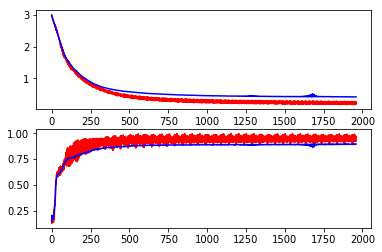

In [5]:
# Experiment 2 Part 1 of End-to-end training with the baseline model model 2.
# Finding the optimal number of iterations for Model 2
# The structure based on Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
# The structure include read in of the input, formatting the input and the conversion of the one-hot encoding.
# The CNN model is written by myself
# The credit of this code goes to Guillaume Chevalier under MIT License.
# Python version 3.6

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

def conv_net(_X):
    _X = tf.reshape(_X, [-1, n_steps, n_input]) 
    # convlution layers
    conv1 = tf.layers.separable_conv1d(_X, 32, 5, activation=tf.nn.relu) 
    conv1 = tf.layers.max_pooling1d(conv1, 20, 2)
    conv2 = tf.layers.separable_conv1d(conv1, 64, 5, activation=tf.nn.relu) 
    fc1 = tf.contrib.layers.flatten(conv2)
    fc1 = tf.layers.dense(fc1, 1024)
    out = tf.layers.dense(fc1, n_classes)
    return out

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


percentage_list = [1]

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]
    
    print(np.array(X_train).shape)
    
    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_height = 1
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0001
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 400  # Loop 300 times on the dataset
    batch_size = 1500
    display_iter = 300000  # To show test set accuracy during training
    
    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])

    pred = conv_net(x)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2# Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)
        
        loss2, acc2 = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss2)
        test_accuracies.append(acc2)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss2) + \
                  ", Accuracy = {}".format(acc2))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")
    runing_time_list.append(time.time() - start_time)
    # Accuracy for test data

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    print("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))

    plt.figure(1)
    plt.subplot(211)
    plt.plot(np.arange(0,len(train_losses),1), train_losses, 'r', np.arange(0,len(test_losses),1), test_losses, 'b')
    plt.subplot(212)
    plt.plot(np.arange(0,len(train_accuracies),1), train_accuracies, 'r', np.arange(0,len(test_accuracies),1), test_accuracies, 'b')
    plt.show()


In [6]:
# Save above results for manuscript plotting later.

import pyexcel as pe

sheet = pe.Sheet([[train_accuracies[i], test_accuracies[i],train_losses[i],test_losses[i]] for i in range(0,len(train_accuracies))])
sheet.save_as("CNN_Training_ACC_LOSS.csv")


In [10]:
# Experiment 2 Part 2 of End-to-end training with the baseline model model 2.
# Try to find the time and accuracy of the models for different sizes of the dataset 
# The structure based on Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
# The structure include read in of the input, formatting the input and the conversion of the one-hot encoding.
# The CNN model is written by myself
# The credit of this code goes to Guillaume Chevalier under MIT License.
# Python version 3.6

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

def conv_net(_X):
    _X = tf.reshape(_X, [-1, n_steps, n_input]) 
    # convlution layers
    conv1 = tf.layers.separable_conv1d(_X, 32, 5, activation=tf.nn.relu) 
    conv1 = tf.layers.max_pooling1d(conv1, 20, 2)
    conv2 = tf.layers.separable_conv1d(conv1, 64, 5, activation=tf.nn.relu) 
    fc1 = tf.contrib.layers.flatten(conv2)
    fc1 = tf.layers.dense(fc1, 1024)
    out = tf.layers.dense(fc1, n_classes)
    return out

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
runing_time_list = []
accuracy_list = []
loss_list = []

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]
    
    print(np.array(X_train).shape)
    
    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_height = 1
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0001
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 250  # Loop 250 times on the dataset
    batch_size = 1500
    display_iter = 300000  # To show test set accuracy during training
    
    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])

    pred = conv_net(x)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2# Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            loss, acc = sess.run(
                [cost, accuracy], 
                feed_dict={
                    x: X_test,
                    y: one_hot(y_test)
                }
            )
            test_losses.append(loss)
            test_accuracies.append(acc)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss) + \
                  ", Accuracy = {}".format(acc))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")
    runing_time_list.append(time.time() - start_time)
    # Accuracy for test data

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    test_losses.append(final_loss)
    test_accuracies.append(accuracy)

    print("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))

    accuracy_list.append(accuracy)
    loss_list.append(final_loss)

print("------------------------")
print("FINAL RESULTS LIST:")
print(runing_time_list)
print(accuracy_list)
print(loss_list)

read in the data
(7352, 1)
(735, 128, 9)
start training
Training iter #1500:   Batch Loss = 2.990879, Accuracy = 0.19066666066646576
PERFORMANCE ON TEST SET: Batch Loss = 2.974717855453491, Accuracy = 0.16830675303936005
Optimization Finished!
Training time is: 62.569679737091064 seconds
FINAL RESULT: Batch Loss = 1.555046558380127, Accuracy = 0.6365795731544495
(7352, 1)
(1470, 128, 9)
start training
Training iter #1500:   Batch Loss = 3.006721, Accuracy = 0.14133332669734955
PERFORMANCE ON TEST SET: Batch Loss = 2.9726974964141846, Accuracy = 0.16864608228206635
Training iter #300000:   Batch Loss = 0.818948, Accuracy = 0.9419999718666077
PERFORMANCE ON TEST SET: Batch Loss = 1.2973253726959229, Accuracy = 0.789616584777832
Optimization Finished!
Training time is: 127.06933259963989 seconds
FINAL RESULT: Batch Loss = 1.1909375190734863, Accuracy = 0.7960637807846069
(7352, 1)
(2206, 128, 9)
start training
Training iter #1500:   Batch Loss = 3.008080, Accuracy = 0.2613333463668823
PER

FINAL RESULT: Batch Loss = 0.4003257751464844, Accuracy = 0.8978622555732727
------------------------
FINAL RESULTS LIST:
[62.569679737091064, 127.06933259963989, 182.46383213996887, 233.86011505126953, 294.6156749725342, 358.1142716407776, 418.9163839817047, 479.87002754211426, 538.2433726787567, 596.057407617569]
[0.6365796, 0.7960638, 0.84458774, 0.867662, 0.8293179, 0.87410927, 0.86935866, 0.88293177, 0.8781812, 0.89786226]
[1.5550466, 1.1909375, 0.9003084, 0.68597245, 0.6606417, 0.5074204, 0.4980302, 0.5091965, 0.45721227, 0.40032578]


In [11]:
# Save above results for manuscript plotting later.

import pyexcel as pe

sheet = pe.Sheet([[runing_time_list[i], accuracy_list[i],loss_list[i]] for i in range(0,len(runing_time_list))])
sheet.save_as("CNN_Mod_Time_ACC_LOSS.csv")

read in the data
(7352, 1)
(7352, 128, 9)
start training
Training iter #1500:   Batch Loss = 3.008119, Accuracy = 0.10533333569765091
PERFORMANCE ON TEST SET: Batch Loss = 2.987088680267334, Accuracy = 0.15371564030647278
Training iter #300000:   Batch Loss = 1.073339, Accuracy = 0.8460000157356262
PERFORMANCE ON TEST SET: Batch Loss = 1.1988846063613892, Accuracy = 0.7529691457748413
Training iter #600000:   Batch Loss = 0.645700, Accuracy = 0.8633333444595337
PERFORMANCE ON TEST SET: Batch Loss = 0.7853507399559021, Accuracy = 0.8347471952438354
Training iter #900000:   Batch Loss = 0.406397, Accuracy = 0.9526666402816772
PERFORMANCE ON TEST SET: Batch Loss = 0.6307153105735779, Accuracy = 0.8561248779296875
Training iter #1200000:   Batch Loss = 0.341885, Accuracy = 0.9493333101272583
PERFORMANCE ON TEST SET: Batch Loss = 0.5546013712882996, Accuracy = 0.8646080493927002
Training iter #1500000:   Batch Loss = 0.326803, Accuracy = 0.9433333277702332
PERFORMANCE ON TEST SET: Batch Los

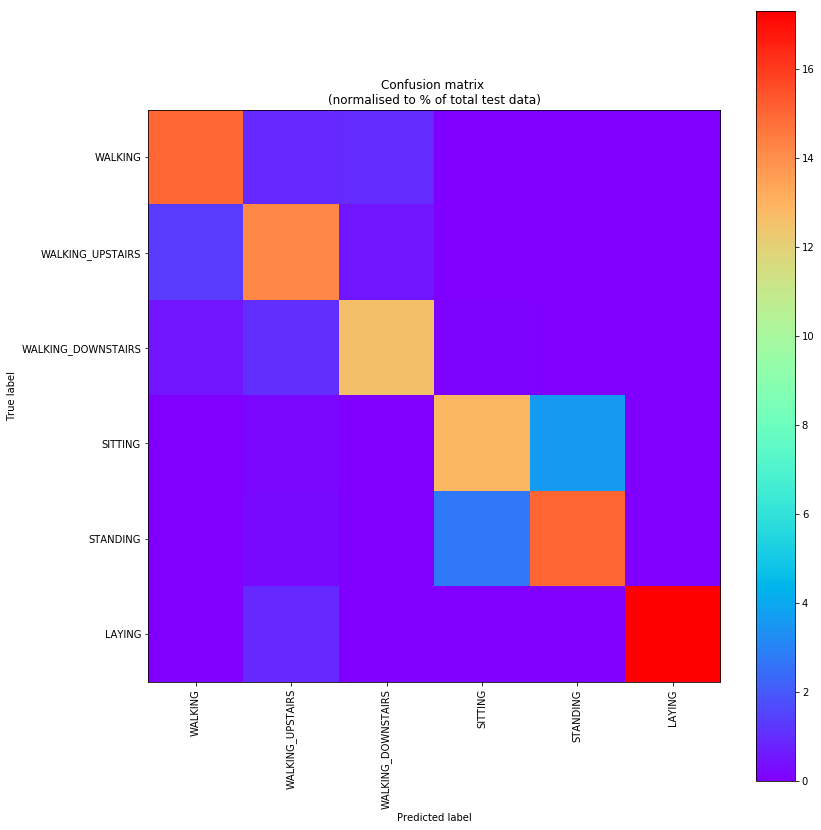

In [2]:
# Plot the confusion matrix to take a look
# The structure based on Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
# The structure include read in of the input, formatting the input and the conversion of the one-hot encoding.
# The CNN model is written by myself

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

def conv_net(_X):
    _X = tf.reshape(_X, [-1, n_steps, n_input]) 
    # convlution layers
    conv1 = tf.layers.separable_conv1d(_X, 32, 5, activation=tf.nn.relu) 
    conv1 = tf.layers.max_pooling1d(conv1, 20, 2)
    conv2 = tf.layers.separable_conv1d(conv1, 64, 5, activation=tf.nn.relu) 
    fc1 = tf.contrib.layers.flatten(conv2)
    fc1 = tf.layers.dense(fc1, 1024)
    out = tf.layers.dense(fc1, n_classes)
    return out

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


percentage_list = [1]

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]
    
    print(np.array(X_train).shape)
    
    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_height = 1
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0001
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 250  # Loop 300 times on the dataset
    batch_size = 1500
    display_iter = 300000  # To show test set accuracy during training
    
    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])

    pred = conv_net(x)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2# Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)
        
        loss2, acc2 = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss2)
        test_accuracies.append(acc2)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss2) + \
                  ", Accuracy = {}".format(acc2))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")
    # Accuracy for test data

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    print("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))

    predictions = one_hot_predictions.argmax(1)
    
    print("Testing Accuracy: {}%".format(100*accuracy))

    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, predictions)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
    # Plot Results: 
    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


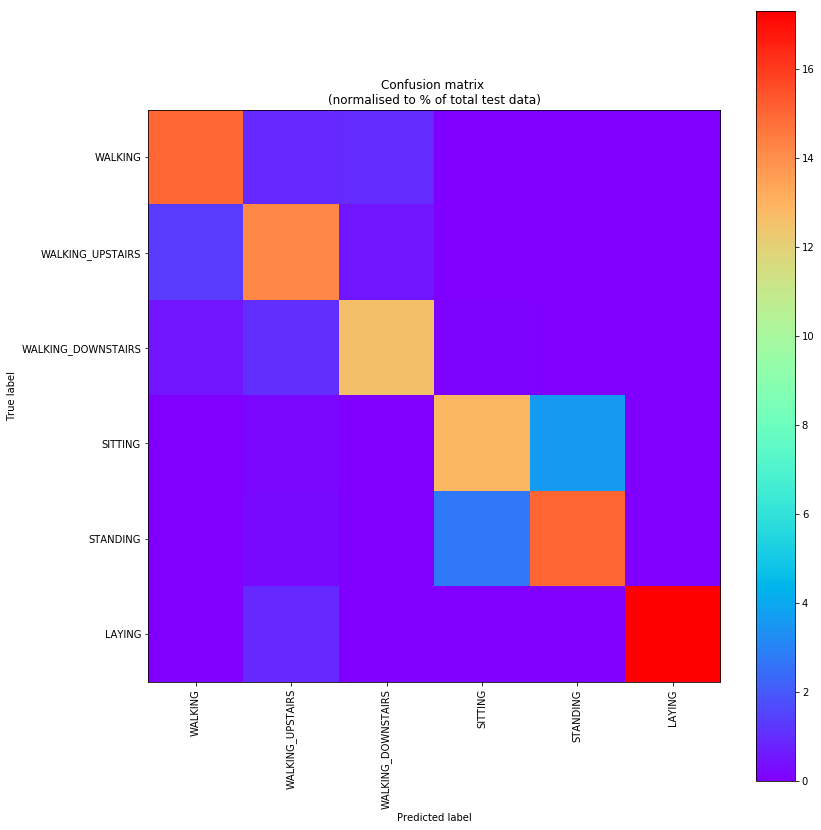

In [3]:
width = 12
height = 12
f = plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
f.savefig("cnn_conf.pdf", bbox_inches='tight')
f.savefig("cnn_conf.png", bbox_inches='tight')